In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
day_price_0_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_0.csv", delimiter=";")
day_price_m1_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-1.csv", delimiter=";")
day_price_m2_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-2.csv", delimiter=";")

# merge all the dataframes
merged_df = pd.concat([day_price_0_df, day_price_m1_df, day_price_m2_df])

Average mean reversion time: 2133.57 timesteps
Maximum deviation magnitude: 0.048884251385488846
Average deviation magnitude: 0.005595280226212094


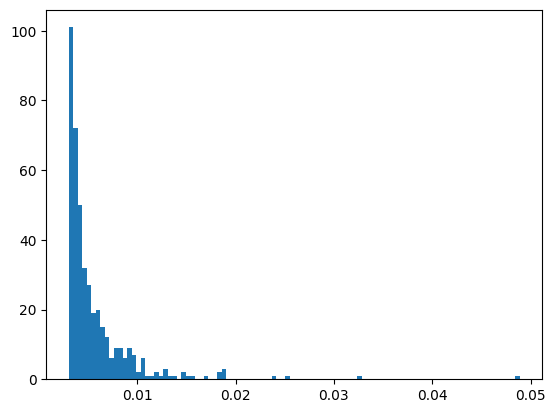

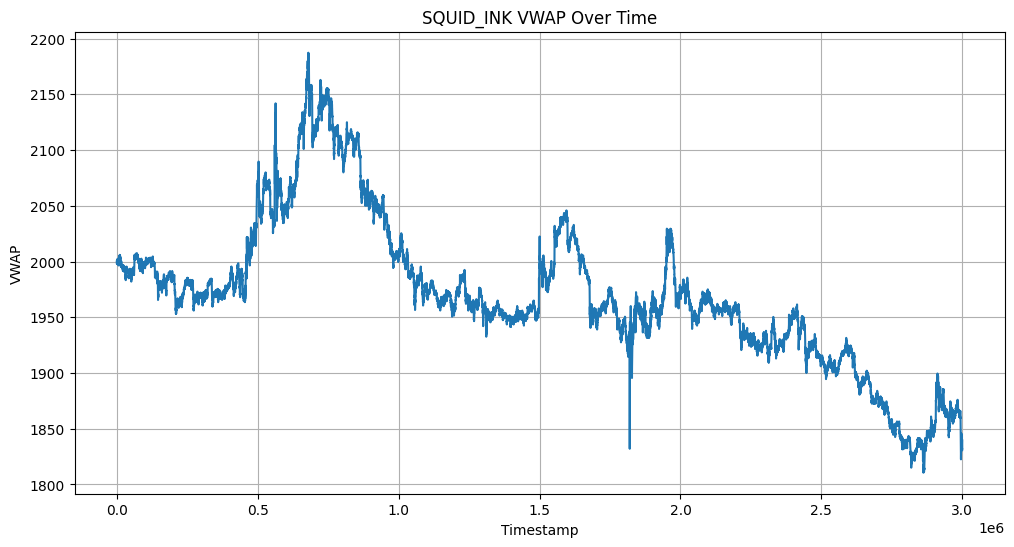

In [23]:
# isolate the squid ink data - create a copy to avoid the warning
squid_ink_df = merged_df[merged_df["product"] == "SQUID_INK"].copy()

squid_ink_df['continuous_timestamp'] = squid_ink_df['timestamp'] + 1e6 * (2 - abs(squid_ink_df['day']))

# Calculate VWAP for each row
def calculate_vwap(row):
    bid_value = sum(
        row[f"bid_price_{i}"] * row[f"bid_volume_{i}"]
        for i in range(1, 4)
        if not (pd.isna(row[f"bid_price_{i}"]) or pd.isna(row[f"bid_volume_{i}"]))
    )
    
    ask_value = sum(
        row[f"ask_price_{i}"] * row[f"ask_volume_{i}"]
        for i in range(1, 4)
        if not (pd.isna(row[f"ask_price_{i}"]) or pd.isna(row[f"ask_volume_{i}"]))
    )
    
    total_volume = sum(
        row[f"{side}_volume_{i}"]
        for side in ["bid", "ask"]
        for i in range(1, 4)
        if not (pd.isna(row[f"{side}_price_{i}"]) or pd.isna(row[f"{side}_volume_{i}"]))
    )
    
    return (bid_value + ask_value) / total_volume if total_volume > 0 else None

# Calculate mid price
def calculate_mid_price(row):
    return (row['ask_price_1'] + row['bid_price_1']) / 2

def calculate_spread(row):
    return row['ask_price_1'] - row['bid_price_1']

# define function to plot volatitlity
def calculate_volatility(data, window_size=20):
    # Calculate log returns
    log_returns = np.log(data['vwap']).diff()
    
    # Calculate rolling standard deviation of log returns
    volatility = log_returns.rolling(window=window_size).std()

    return volatility

# Apply VWAP calculation to each row
squid_ink_df['vwap'] = squid_ink_df.apply(calculate_vwap, axis=1)

# Apply mid price calculation to each row
squid_ink_df['mid_price'] = squid_ink_df.apply(calculate_mid_price, axis=1)

# Apply spread calculation to each row
squid_ink_df['spread'] = squid_ink_df.apply(calculate_spread, axis=1)

# Apply return calculation to each row
squid_ink_df['return'] = squid_ink_df['vwap'].pct_change()

# calculate log returns
squid_ink_df['log_returns'] = np.log(squid_ink_df['vwap']).diff()

# calculate volatility
squid_ink_df['volatility'] = calculate_volatility(squid_ink_df)

# Sort by continuous timestamp
squid_ink_df = squid_ink_df.sort_values('continuous_timestamp')

# moving average function 
def moving_average(data, window_size=50):
    return data.rolling(window=window_size).mean()

# apply moving average to vwap
squid_ink_df['vwap_ma'] = moving_average(squid_ink_df['vwap'])

# Calculate mean reversion time
def calculate_mean_reversion_time(data, threshold=0.5):
    """
    Calculate average time for price to revert to mean
    threshold: how close to mean we consider "reverted" (as fraction of standard deviation)
    """
    # Calculate deviations from moving average
    deviations = (data['vwap'] - data['vwap_ma'])/data['vwap_ma']
    std_dev = deviations.std()
    
    # Track crossing points
    reversion_times = []
    deviation_magnitudes = []
    deviation_start = None
    start_time = None
    current_deviation_points = []
    
    for idx, row in data.iterrows():
        deviation = (row['vwap'] - row['vwap_ma'])/row['vwap_ma']
        
        # If we're not tracking a deviation and find significant one
        if deviation_start is None and abs(deviation) > std_dev:
            deviation_start = deviation
            start_time = row['continuous_timestamp']
            current_deviation_points = [deviation]
            
        # If we're tracking a deviation
        elif deviation_start is not None:
            current_deviation_points.append(deviation)
            
            # Check if price reverts within threshold
            if abs(deviation) < (threshold * std_dev):
                # Record time taken and magnitude
                reversion_time = row['continuous_timestamp'] - start_time
                reversion_times.append(reversion_time)
                deviation_magnitudes.append(max(abs(d) for d in current_deviation_points))
                
                # Reset tracking
                deviation_start = None
                current_deviation_points = []
            
    results = {}
    if reversion_times:
        results['avg_reversion_time'] = np.mean(reversion_times)
        print(f"Average mean reversion time: {results['avg_reversion_time']:.2f} timesteps")
    
    if deviation_magnitudes:
        results['max_deviation'] = max(deviation_magnitudes)
        results['deviation_magnitudes'] = deviation_magnitudes
        results['avg_deviation'] = np.mean(deviation_magnitudes)
        print(f"Maximum deviation magnitude: {results['max_deviation']}")
        print(f"Average deviation magnitude: {results['avg_deviation']}")
        return results
    
    print("No mean reversions detected")
    return None

# Calculate mean reversion statistics
reversion_stats = calculate_mean_reversion_time(squid_ink_df)

plt.hist(reversion_stats['deviation_magnitudes'], bins=100)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["vwap"])
plt.title("SQUID_INK VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()


In [46]:
# for each timestep, count the spread
spread_counts = defaultdict(int)
for idx, row in squid_ink_df.iterrows():
    if pd.notna(row["spread"]):
        spread_counts[row["spread"]] += 1

# plot spread counts
print(spread_counts)

# for each timestep, count the spread
spread_counts = defaultdict(int)
for idx, row in kelp_df.iterrows():
    if pd.notna(row["spread"]):
        spread_counts[row["spread"]] += 1

# plot spread counts
print(spread_counts)

defaultdict(<class 'int'>, {4: 3782, 2: 5590, 3: 16518, 1: 4110})
defaultdict(<class 'int'>, {4: 4730, 2: 5664, 3: 15756, 1: 3850})


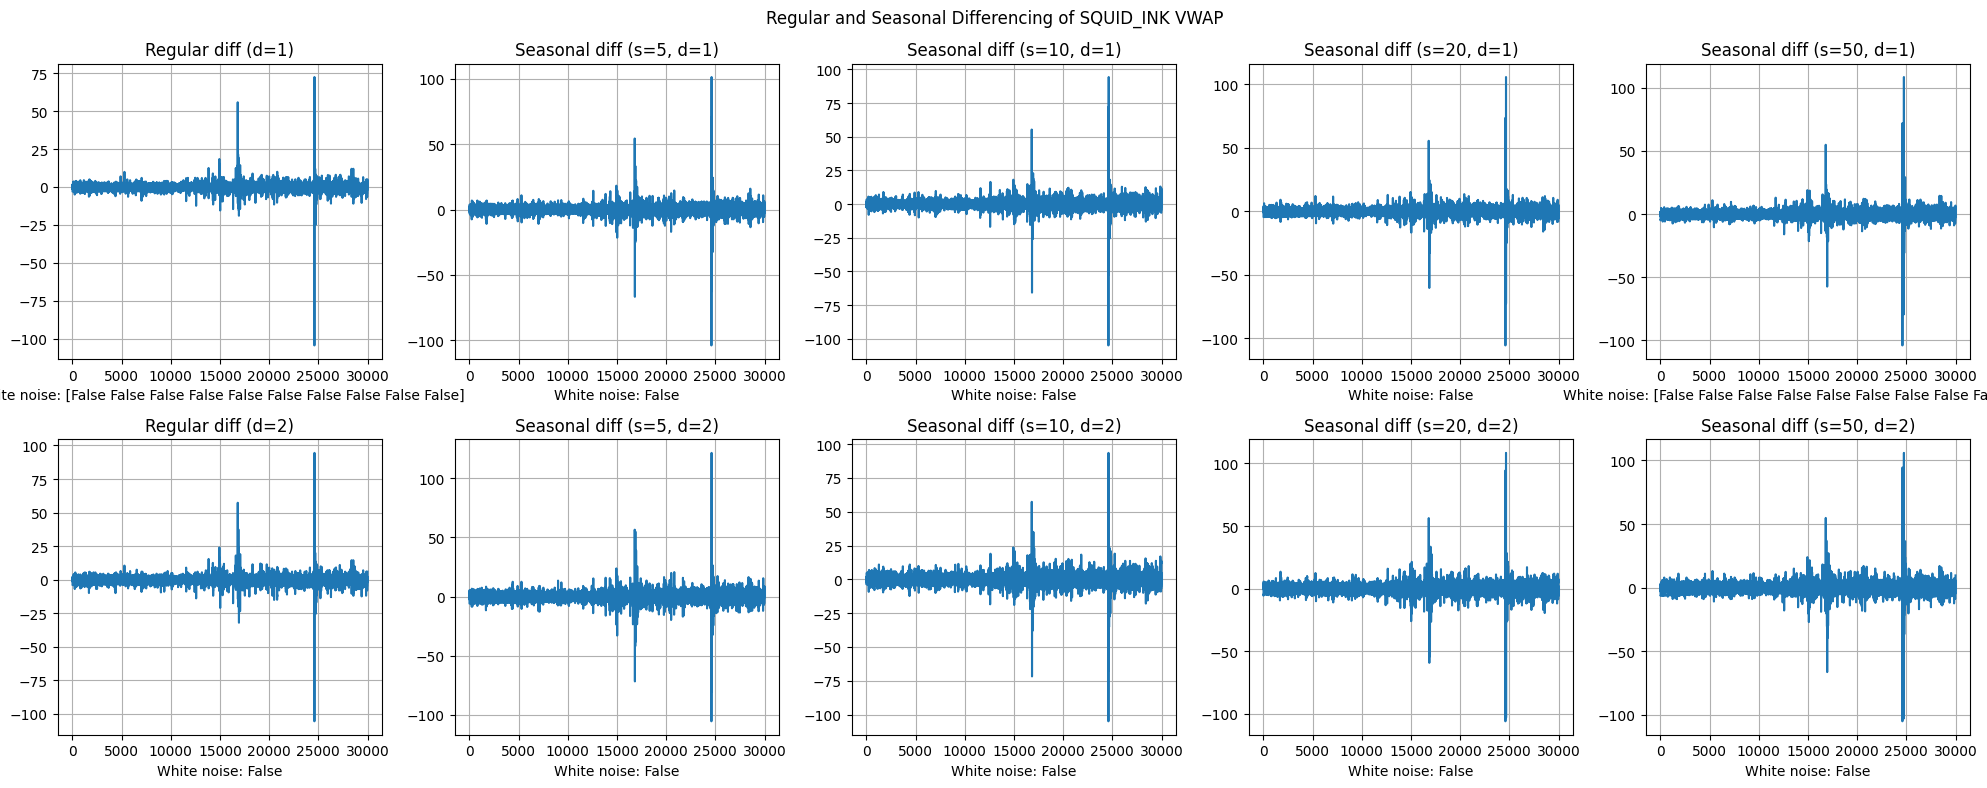


Summary Statistics:

Regular Differencing:

d=1:
Mean: -0.0054
Std: 1.6512
Is White Noise: [False False False False False False False False False False]

d=2:
Mean: -0.0107
Std: 2.2109
Is White Noise: False

Seasonal Differencing:

s=5, d=1:
Mean: 0.0003
Std: 2.3209
Is White Noise: False

s=5, d=2:
Mean: 0.0006
Std: 3.1310
Is White Noise: False

s=10, d=1:
Mean: 0.0002
Std: 2.2791
Is White Noise: False

s=10, d=2:
Mean: 0.0003
Std: 3.0368
Is White Noise: False

s=20, d=1:
Mean: -0.0002
Std: 2.3334
Is White Noise: False

s=20, d=2:
Mean: -0.0003
Std: 3.1272
Is White Noise: False

s=50, d=1:
Mean: -0.0001
Std: 2.3430
Is White Noise: [False False False False False False False False False False]

s=50, d=2:
Mean: -0.0004
Std: 3.1344
Is White Noise: False


In [6]:
# # Calculate and plot differenced series at different degrees and seasonal periods
# from statsmodels.tsa.stattools import acf
# import scipy.stats as stats

# def check_white_noise(series):
#     # Perform Ljung-Box test
#     acf_values = acf(series, nlags=20)
#     lb_stat, lb_pvalue = acf(series, nlags=10, qstat=True)[1:]
    
#     # Check if autocorrelations are close to zero
#     is_white = np.all(np.abs(acf_values[1:]) < 0.2) and lb_pvalue > 0.05
    
#     return is_white

# # Different degrees of differencing
# degrees = [1, 2]
# # Different seasonal periods to try
# seasonal_periods = [5, 10, 20, 50]

# fig, axes = plt.subplots(len(degrees), len(seasonal_periods)+1, figsize=(20, 8))
# fig.suptitle('Regular and Seasonal Differencing of SQUID_INK VWAP')

# for i, d in enumerate(degrees):
#     # Regular differencing
#     diff_series = squid_ink_df['vwap'].diff(d).dropna()
    
#     axes[i,0].plot(diff_series)
#     axes[i,0].set_title(f'Regular diff (d={d})')
#     axes[i,0].grid(True)
    
#     is_white = check_white_noise(diff_series)
#     axes[i,0].set_xlabel(f'White noise: {is_white}')
    
#     # Seasonal differencing
#     for j, s in enumerate(seasonal_periods):
#         seas_diff = squid_ink_df['vwap'].diff(s).dropna()
#         # Apply regular differencing on top if d > 0
#         if d > 0:
#             seas_diff = seas_diff.diff(d).dropna()
            
#         axes[i,j+1].plot(seas_diff)
#         axes[i,j+1].set_title(f'Seasonal diff (s={s}, d={d})')
#         axes[i,j+1].grid(True)
        
#         is_white = check_white_noise(seas_diff)
#         axes[i,j+1].set_xlabel(f'White noise: {is_white}')

# plt.tight_layout()
# plt.show()

# # Print summary statistics for each differencing
# print("\nSummary Statistics:")
# print("\nRegular Differencing:")
# for d in degrees:
#     diff = squid_ink_df['vwap'].diff(d).dropna()
#     print(f"\nd={d}:")
#     print(f"Mean: {diff.mean():.4f}")
#     print(f"Std: {diff.std():.4f}")
#     print(f"Is White Noise: {check_white_noise(diff)}")

# print("\nSeasonal Differencing:")
# for s in seasonal_periods:
#     for d in degrees:
#         seas_diff = squid_ink_df['vwap'].diff(s).dropna()
#         if d > 0:
#             seas_diff = seas_diff.diff(d).dropna()
#         print(f"\ns={s}, d={d}:")
#         print(f"Mean: {seas_diff.mean():.4f}")
#         print(f"Std: {seas_diff.std():.4f}")
#         print(f"Is White Noise: {check_white_noise(seas_diff)}")


In [60]:
# help(np.diff)

Help on _ArrayFunctionDispatcher in module numpy:

diff(a, n=1, axis=-1, prepend=<no value>, append=<no value>)
    Calculate the n-th discrete difference along the given axis.

    The first difference is given by ``out[i] = a[i+1] - a[i]`` along
    the given axis, higher differences are calculated by using `diff`
    recursively.

    Parameters
    ----------
    a : array_like
        Input array
    n : int, optional
        The number of times values are differenced. If zero, the input
        is returned as-is.
    axis : int, optional
        The axis along which the difference is taken, default is the
        last axis.
    prepend, append : array_like, optional
        Values to prepend or append to `a` along axis prior to
        performing the difference.  Scalar values are expanded to
        arrays with length 1 in the direction of axis and the shape
        of the input array in along all other axes.  Otherwise the
        dimension and shape must match `a` except along

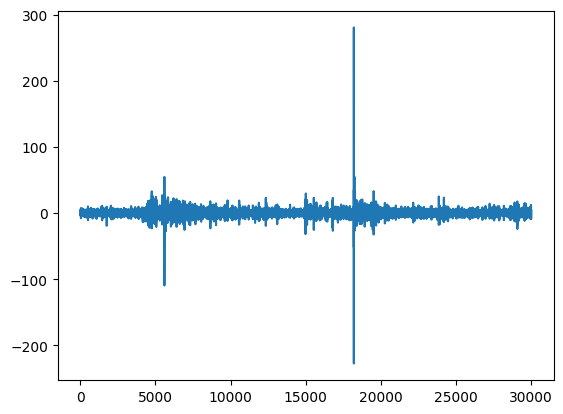

In [72]:
# acf

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# 1. Plot time series
ts = np.array(squid_ink_df["vwap"])

plt.plot(np.diff(ts, 3))


2.6657333333333333
1 4


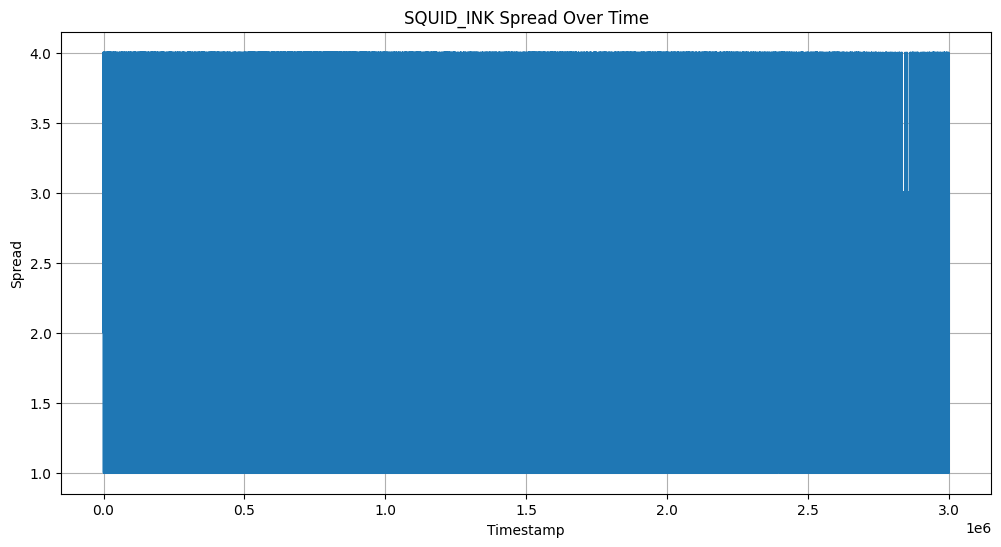

In [ ]:
# average spread
print(squid_ink_df["spread"].mean())

# range spread
print(min(squid_ink_df["spread"]), max(squid_ink_df["spread"]))

# plot spread of squid ink
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["spread"])
plt.title("SQUID_INK Spread Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.grid(True)

-0.053963335915311106 0.08943510356937923
1.050075599713215e-06


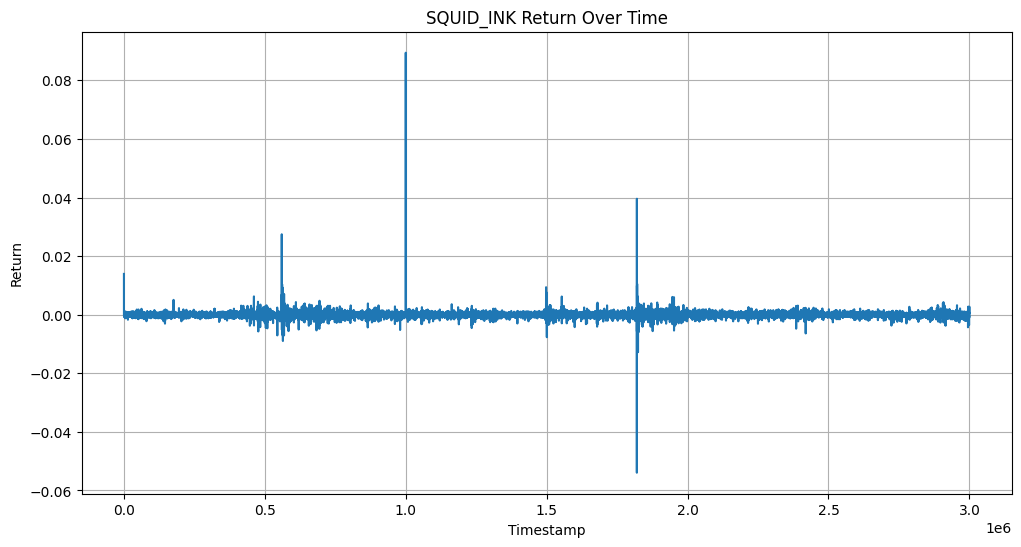

In [14]:
# calculate return range 
print(min(squid_ink_df["return"]), max(squid_ink_df["return"]))

# calculate average return
print(squid_ink_df["return"].mean())

# plot return of squid ink
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["return"])
plt.title("SQUID_INK Return Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Return")
plt.grid(True)

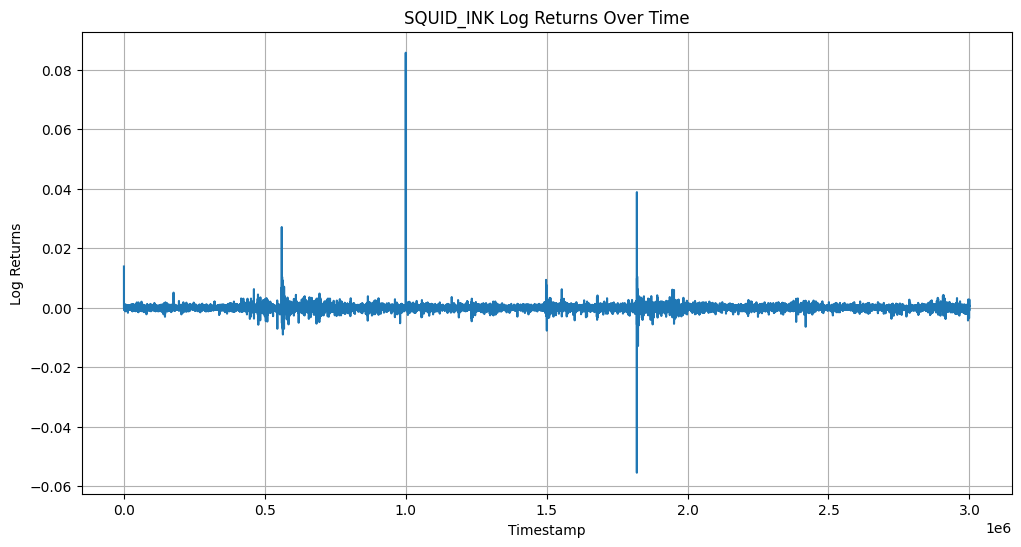

In [27]:
# log returns
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["log_returns"])
plt.title("SQUID_INK Log Returns Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Log Returns")
plt.grid(True)


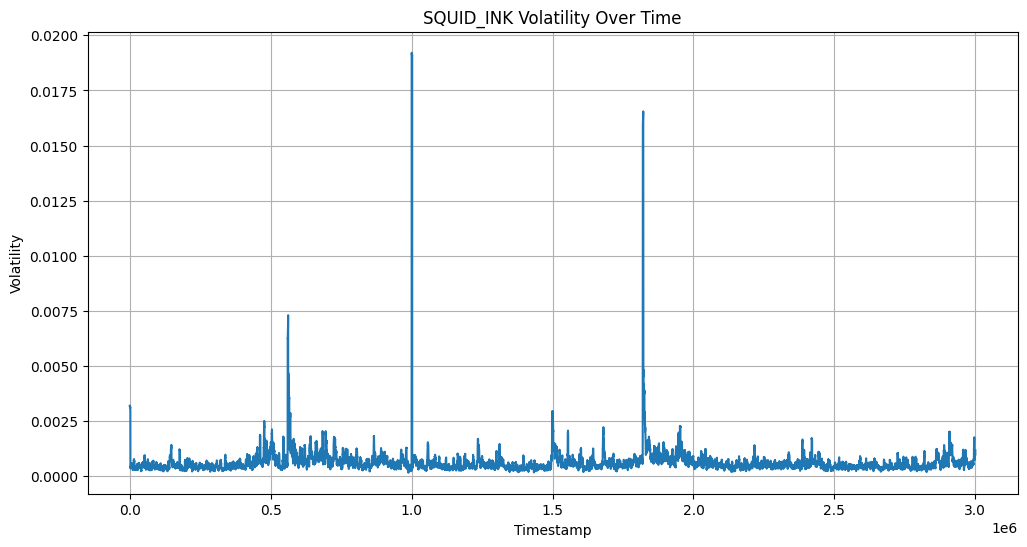

In [31]:
# volatility
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["volatility"])
plt.title("SQUID_INK Volatility Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Volatility")
# plt.xlim()
plt.grid(True)

Frequency with highest power: 0.001000
Corresponding period: 1000.00 time units


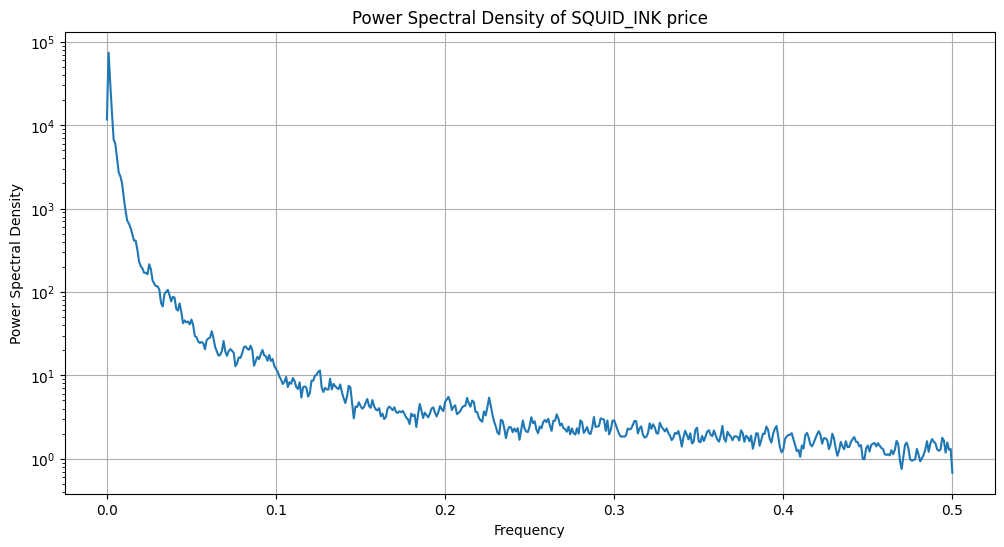

In [55]:
import matplotlib.pyplot as plt
from scipy.signal import welch

# Calculate log returns for squid ink
squid_ink_log_returns = np.log(squid_ink_df['vwap']).diff().dropna()

# Compute power spectral density using Welch's method
frequencies, psd = welch(squid_ink_df['vwap'], nperseg=1000)

# Find frequency with maximum power
max_psd_idx = np.argmax(psd)
max_freq = frequencies[max_psd_idx]

# Calculate period (1/frequency)
period = 1/max_freq if max_freq != 0 else float('inf')

print(f"Frequency with highest power: {max_freq:.6f}")
print(f"Corresponding period: {period:.2f} time units")


# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density of SQUID_INK price')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()


Average mean reversion time: -4103.84 timesteps
Maximum deviation magnitude: 0.02
Average deviation magnitude: 0.00


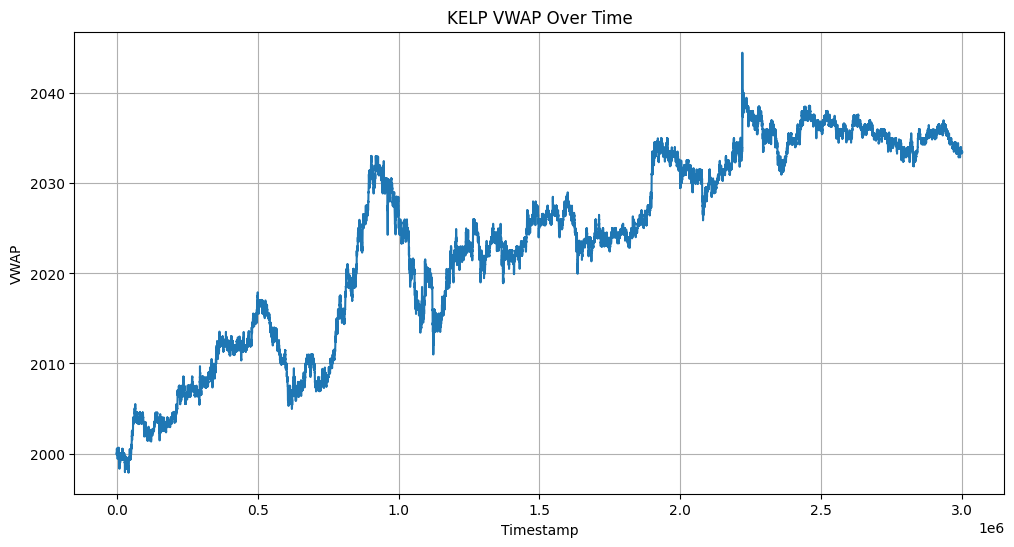

In [16]:
# do the same for kelp
kelp_df = merged_df[merged_df["product"] == "KELP"].copy()

kelp_df['continuous_timestamp'] = kelp_df['timestamp'] + 1e6 * (2 - abs(kelp_df['day']))

# Calculate VWAP for each row
kelp_df['vwap'] = kelp_df.apply(calculate_vwap, axis=1)

# Calculate mid price
kelp_df['mid_price'] = kelp_df.apply(calculate_mid_price, axis=1)

# Apply spread calculation to each row
kelp_df['spread'] = kelp_df.apply(calculate_spread, axis=1)

# Apply return calculation to each row
kelp_df['return'] = kelp_df['vwap'].pct_change()

# apply moving average to vwap
kelp_df['vwap_ma'] = moving_average(kelp_df['vwap'])

# Calculate mean reversion time
reversion_stats = calculate_mean_reversion_time(kelp_df)

# sort
kelp_df = kelp_df.sort_values('continuous_timestamp')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(kelp_df["continuous_timestamp"], kelp_df["vwap"])
plt.title("KELP VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()

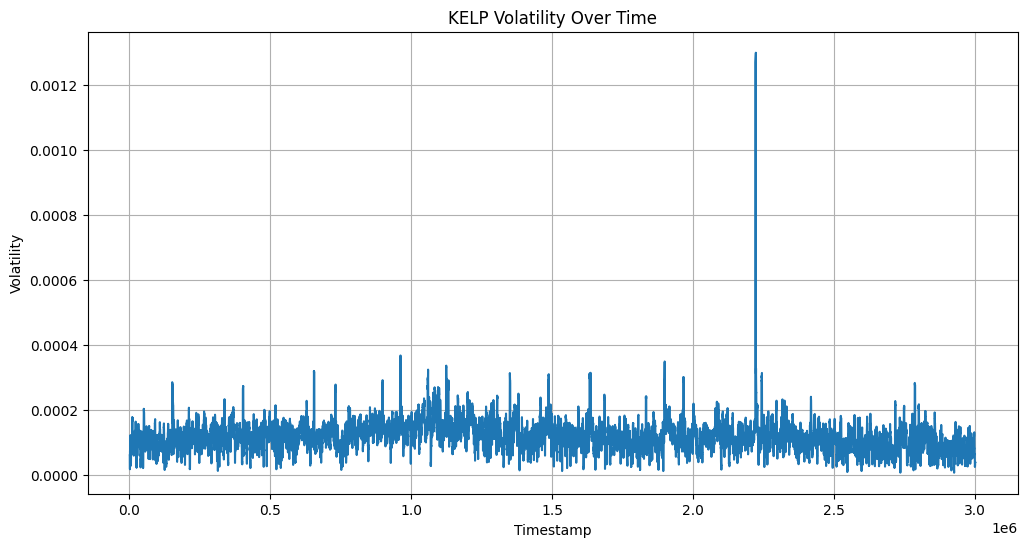

In [9]:
kelp_df["volatility"] = calculate_volatility(kelp_df)

# plot volatility
plt.figure(figsize=(12, 6))
plt.plot(kelp_df["continuous_timestamp"], kelp_df["volatility"])
plt.title("KELP Volatility Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


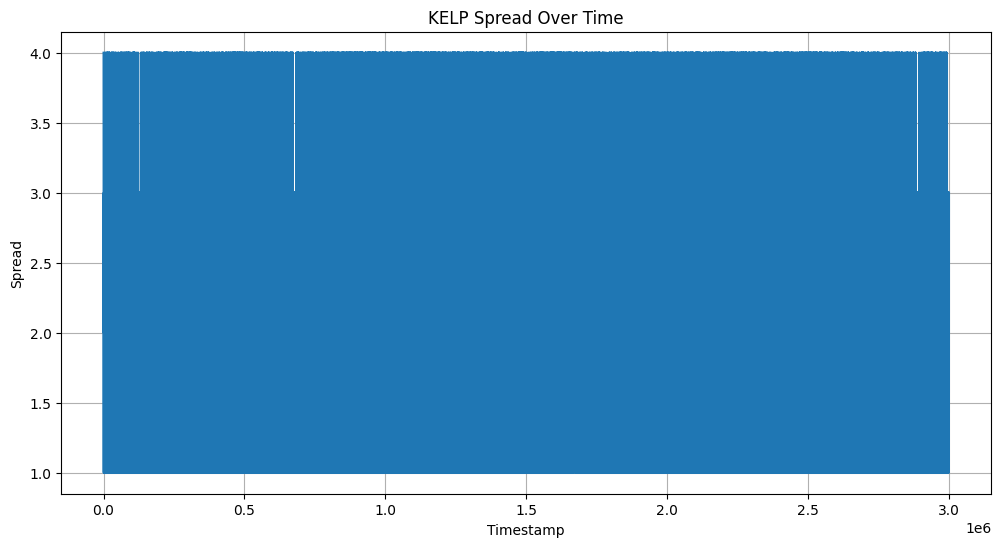

In [16]:
# plot spread
plt.figure(figsize=(12, 6))
plt.plot(kelp_df["continuous_timestamp"], kelp_df["spread"])
plt.title("KELP Spread Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.grid(True)

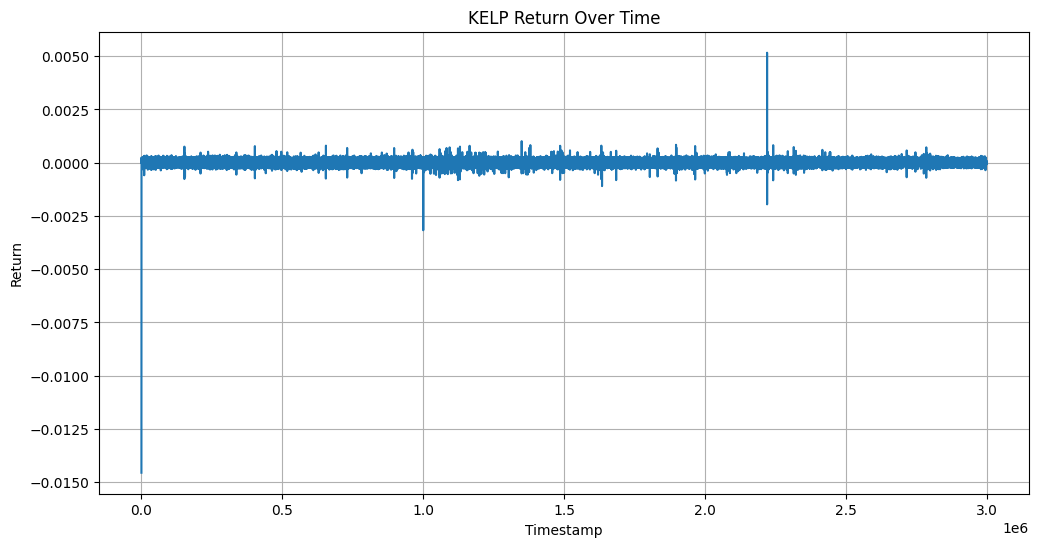

In [17]:
# plot return
plt.figure(figsize=(12, 6))
plt.plot(kelp_df["continuous_timestamp"], kelp_df["return"])
plt.title("KELP Return Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Return")
plt.grid(True)


66.3121564108053


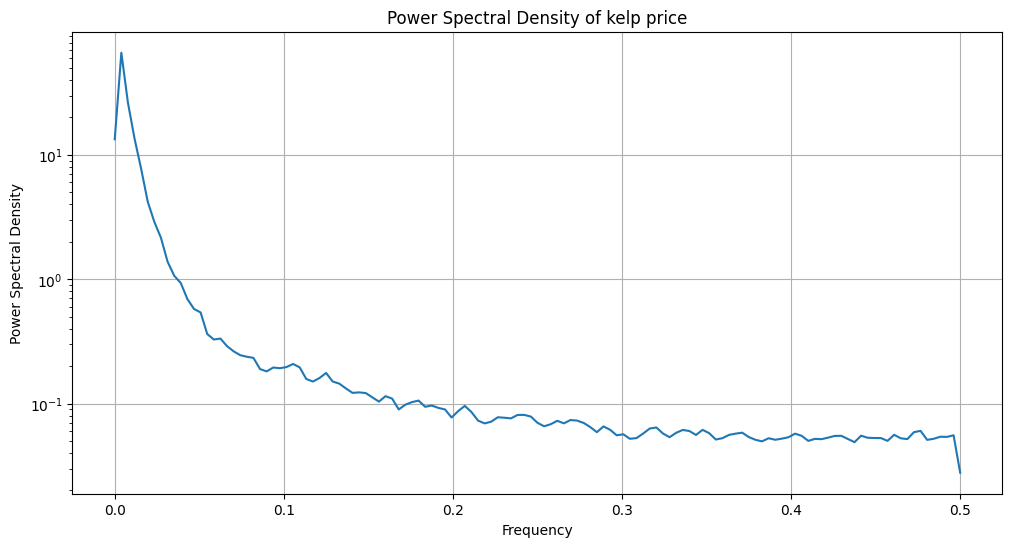

In [38]:
# Compute power spectral density using Welch's method
frequencies, psd = welch(kelp_df['vwap'], nperseg=256)

print(max(psd))

# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density of kelp price')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()


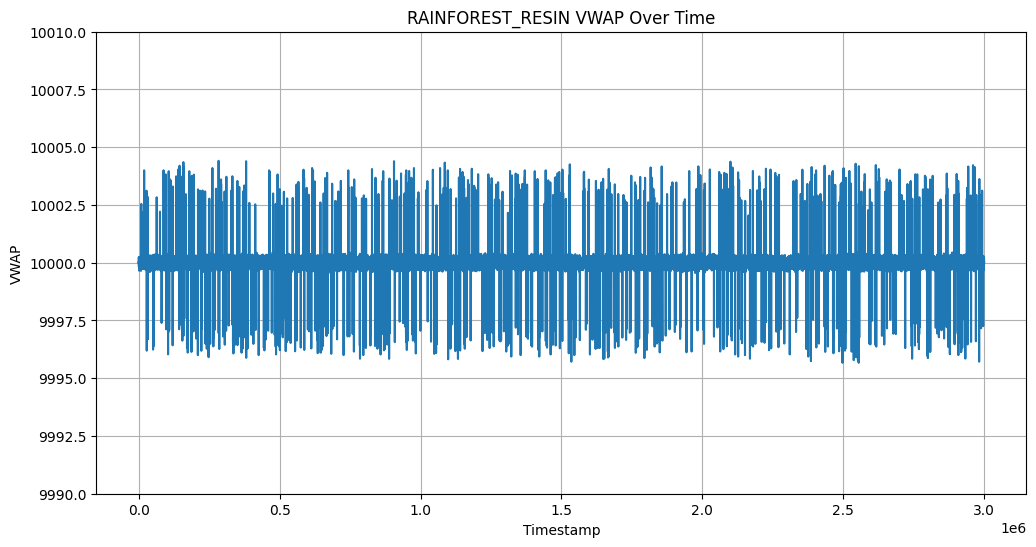

9995.666666666666 10004.411764705883


In [25]:
# rainforest resin
rainforest_resin_df = merged_df[merged_df["product"] == "RAINFOREST_RESIN"].copy()

rainforest_resin_df['continuous_timestamp'] = rainforest_resin_df['timestamp'] + 1e6 * (2 - abs(rainforest_resin_df['day']))

# Calculate VWAP for each row
rainforest_resin_df['vwap'] = rainforest_resin_df.apply(calculate_vwap, axis=1)

# Calculate mid price
rainforest_resin_df['mid_price'] = rainforest_resin_df.apply(calculate_mid_price, axis=1)

# Apply spread calculation to each row
rainforest_resin_df['spread'] = rainforest_resin_df.apply(calculate_spread, axis=1)

# Apply return calculation to each row
rainforest_resin_df['return'] = rainforest_resin_df['vwap'].pct_change()

# sort
rainforest_resin_df = rainforest_resin_df.sort_values('continuous_timestamp')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rainforest_resin_df["continuous_timestamp"], rainforest_resin_df["vwap"])
plt.ylim(9990, 10010)
plt.title("RAINFOREST_RESIN VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()

print(min(rainforest_resin_df["vwap"]), max(rainforest_resin_df["vwap"]))


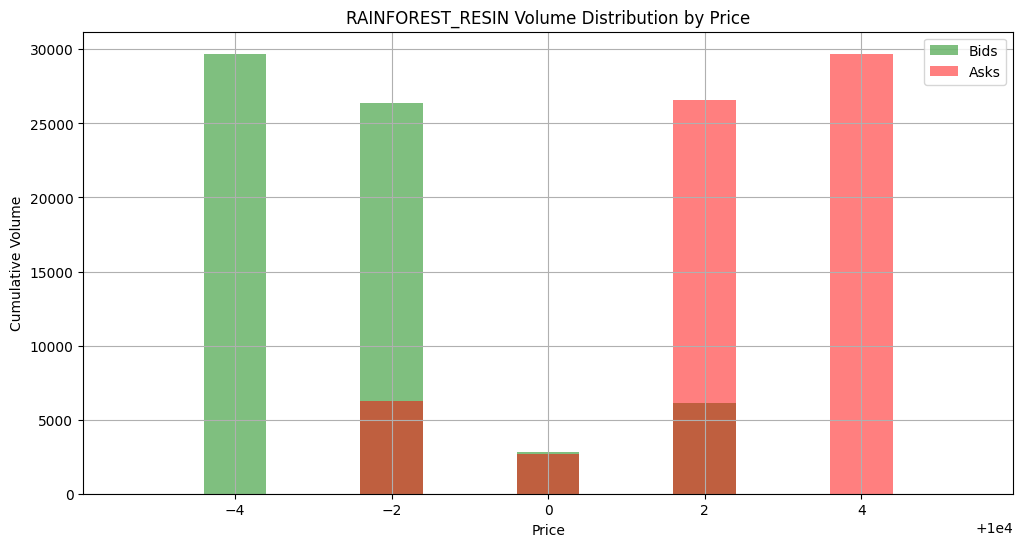

In [50]:
# Calculate volume at each price point for bids and asks
from collections import defaultdict

bid_volumes = defaultdict(int)
ask_volumes = defaultdict(int)

for idx, row in rainforest_resin_df.iterrows():
    if pd.notna(row["bid_price_1"]):
        bid_volumes[row["bid_price_1"]] += row["bid_volume_1"]
    if pd.notna(row["ask_price_1"]):
        ask_volumes[row["ask_price_1"]] += row["ask_volume_1"]
    if pd.notna(row["bid_price_2"]):
        bid_volumes[row["bid_price_2"]] += row["bid_volume_2"]
    if pd.notna(row["ask_price_2"]):
        ask_volumes[row["ask_price_2"]] += row["ask_volume_2"]
    if pd.notna(row["bid_price_3"]):
        bid_volumes[row["bid_price_3"]] += row["bid_volume_3"]
    if pd.notna(row["ask_price_3"]):
        ask_volumes[row["ask_price_3"]] += row["ask_volume_3"]

# Add boundary points for visualization
bid_volumes[9995] = 0  # Use numeric instead of string
ask_volumes[10005] = 0  # Use numeric instead of string

# Plot bid/ask volumes
plt.figure(figsize=(12, 6))
plt.bar([float(x) for x in bid_volumes.keys()], bid_volumes.values(), alpha=0.5, label='Bids', color='green')
plt.bar([float(x) for x in ask_volumes.keys()], ask_volumes.values(), alpha=0.5, label='Asks', color='red')
plt.title("RAINFOREST_RESIN Volume Distribution by Price")
plt.xlabel("Price")
plt.ylabel("Cumulative Volume")
plt.legend()
plt.grid(True)
plt.show()



In [52]:
# print dicts
print(bid_volumes)
print(ask_volumes)


defaultdict(<class 'int'>, {9996: 29705.0, 9995.0: 0, 10000: 2833.0, 9998: 26406.0, 10002: 6132})
defaultdict(<class 'int'>, {10004: 29705.0, 10005.0: 0, 9998: 6229, 10002.0: 26597.0, 10000: 2663.0})


6.773833333333333
2 10


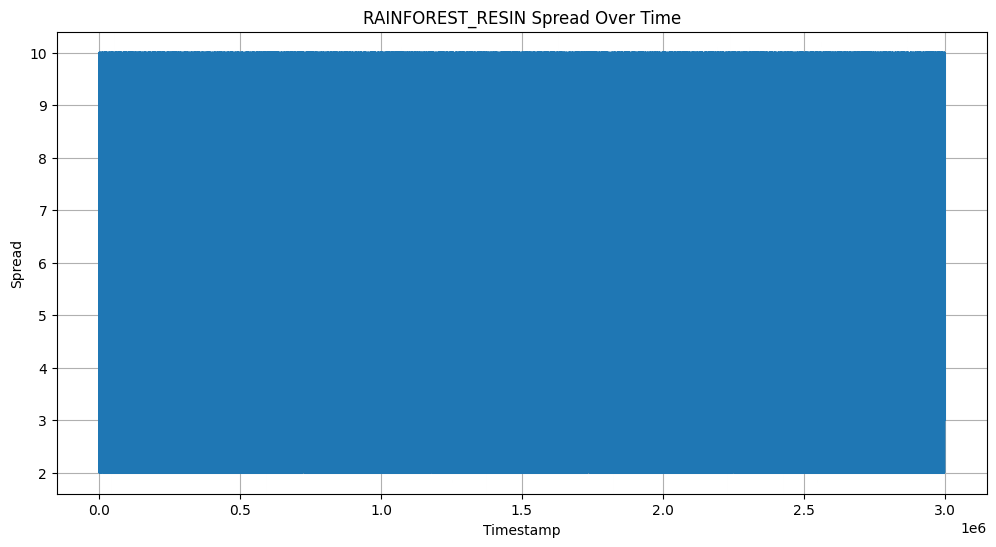

In [21]:
# mean spread
print(rainforest_resin_df["spread"].mean())

# range spread
print(min(rainforest_resin_df["spread"]), max(rainforest_resin_df["spread"]))

# Plot spread
plt.figure(figsize=(12, 6))
plt.plot(rainforest_resin_df["continuous_timestamp"], rainforest_resin_df["spread"])
plt.title("RAINFOREST_RESIN Spread Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.grid(True)
plt.show()


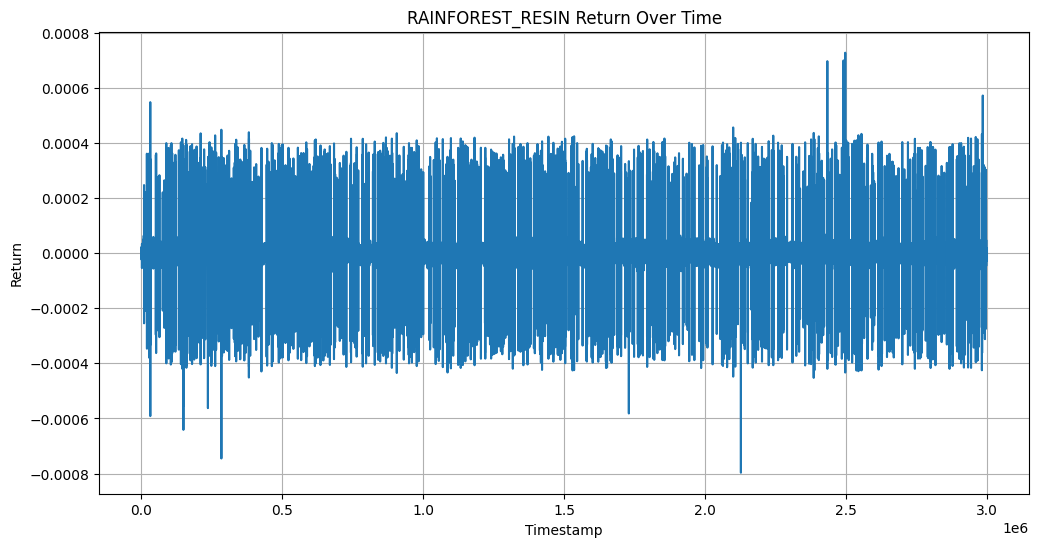

In [20]:
# plot return
plt.figure(figsize=(12, 6))
plt.plot(rainforest_resin_df["continuous_timestamp"], rainforest_resin_df["return"])
plt.title("RAINFOREST_RESIN Return Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Return")
plt.grid(True)

0.8008973151618207


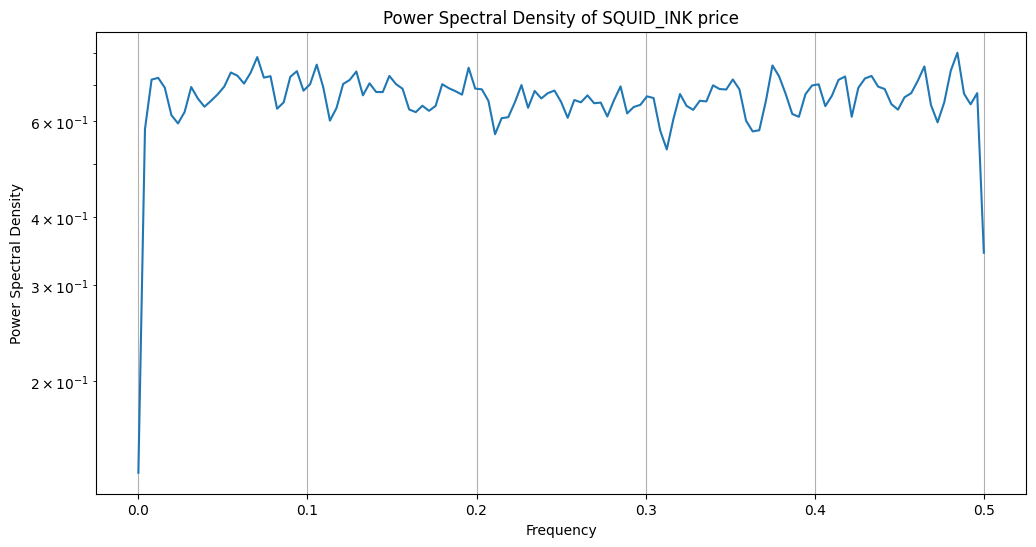

In [39]:
# PSD for rainforest resin
# Compute power spectral density using Welch's method
frequencies, psd = welch(rainforest_resin_df['vwap'], nperseg=256)

print(max(psd))

# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density of SQUID_INK price')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()



In [ ]:
# Now fit SARIMA model using pmdarima
import pmdarima as pm

# Create the SARIMA model
model = pm.auto_arima(squid_ink_df['vwap'].dropna(),
                     start_p=1, start_q=1,
                     test='adf',
                     max_p=3, max_q=3,
                     m=12,  # frequency for seasonal differencing
                     start_P=0, seasonal=True,
                     d=1, D=1, # difference order
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)

print(model.summary())

# Plot diagnostics
model.plot_diagnostics(figsize=(12, 8))
plt.show()

/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=62.52 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=145533.837, Time=1.19 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=135800.100, Time=5.82 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=24.88 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=145411.055, Time=1.24 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=132439.329, Time=14.89 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=166.91 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=46.65 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AIC=132593.788, Time=10.41 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[12]             : AIC=132393.306, Time=18.85 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=135740.071, Time=7.48 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 